The goal here is to reduce the dimension of our original dataframe using Lasso.
<br>
with this we can try to select the most important traits for the model that will predict which anime to watch.

In [1]:
from AniList_extractor import AniListUser
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import compress

In [2]:
df_completed, df_plan_to_watch, df_dropped = AniListUser('thems22').get_dfs()
#ms22_df_completed, ms22_df_plan_to_watch, _ = AniListUser('thems22').get_dfs()

In [3]:
from sklearn.preprocessing import KBinsDiscretizer
bins = KBinsDiscretizer(n_bins=4, strategy='quantile', encode='ordinal')
bins.fit(df_completed[['score']].values)
df_completed['groups'] = bins.transform(df_completed[['score']].values)
min_score_grp = df_completed.groupby('groups')['score'].mean().sort_values().index[0]
df_dropped['groups'] = min_score_grp
df_final = pd.concat([df_completed, df_dropped], ignore_index=True)
df_final = df_final.reset_index(drop=True)
df_final['english'] = np.where(df_final['english'].isnull(), df_final['romaji'], df_final['english'])

In [4]:
df_completed.groupby('groups')['score'].agg(['mean', 'count', 'unique'])

,mean,count,unique
groups,,,
0.0,5.500000,30,"[5, 6, 2, 4]"
1.0,7.000000,53,[7]
2.0,8.000000,79,[8]
3.0,9.489796,98,"[9, 10]"


In [5]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier

In [6]:
cv = StratifiedKFold(3)
clf = ExtraTreeClassifier(class_weight='balanced')

In [7]:
main_columns = ['tags', 'genres', 'score', 'description', 'romaji', 'english', 'native', 'userPreferred', 'groups']
tags_columns = [i for i in df_final.columns if i not in main_columns]

In [8]:
df_final[tags_columns] = df_final[tags_columns].fillna(0)

<AxesSubplot: >

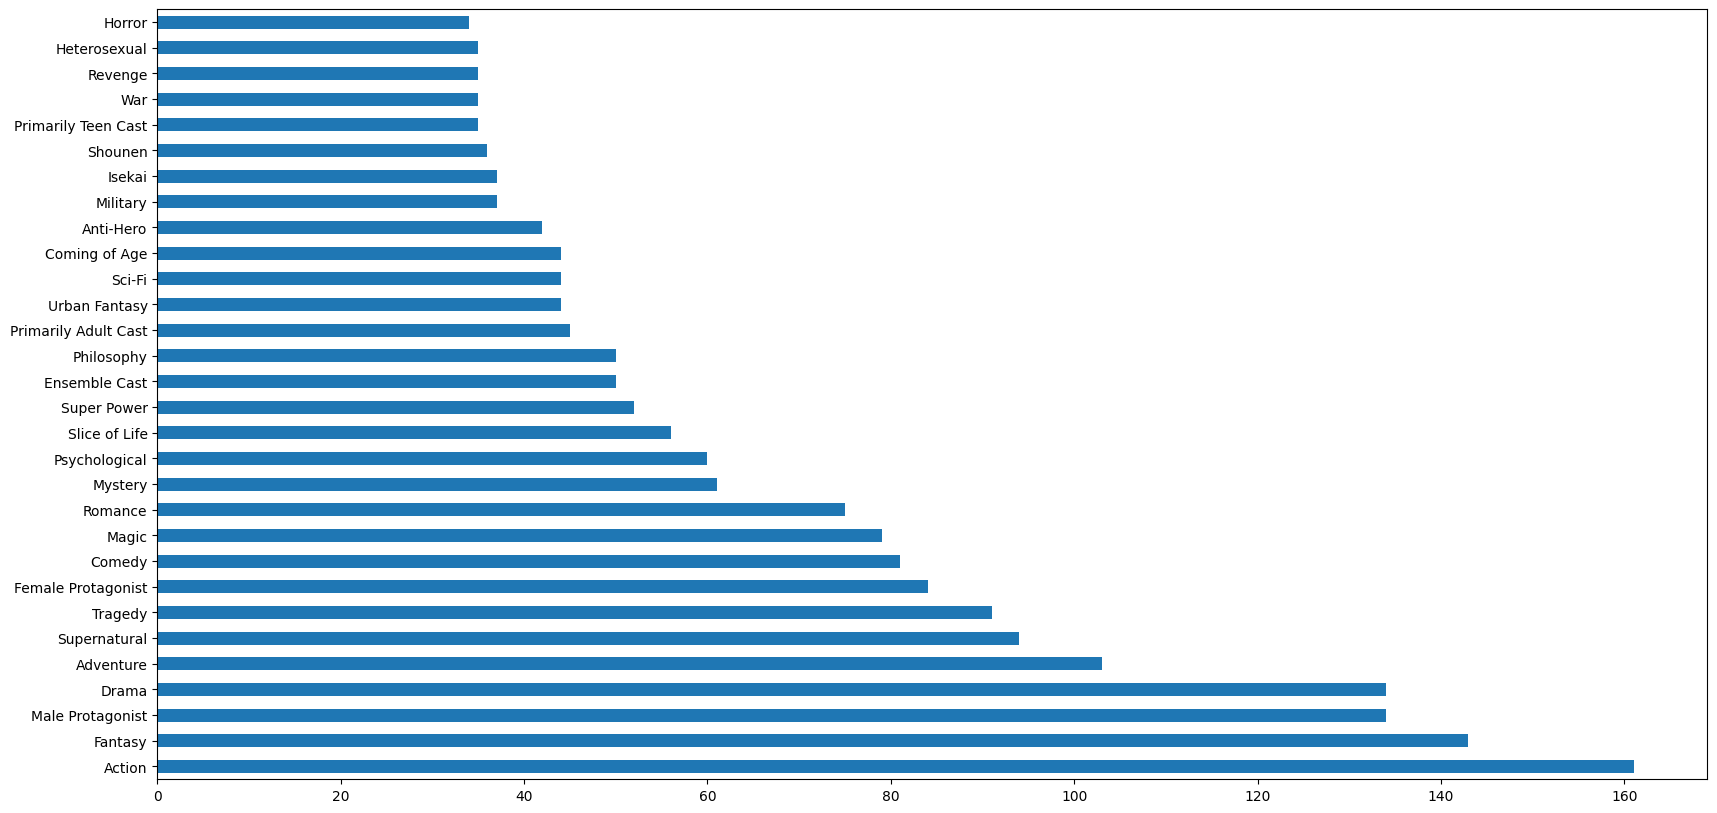

In [9]:
df_final[tags_columns].sum().sort_values(ascending=False).head(30).plot(kind='barh', figsize=(20, 10))

<AxesSubplot: >

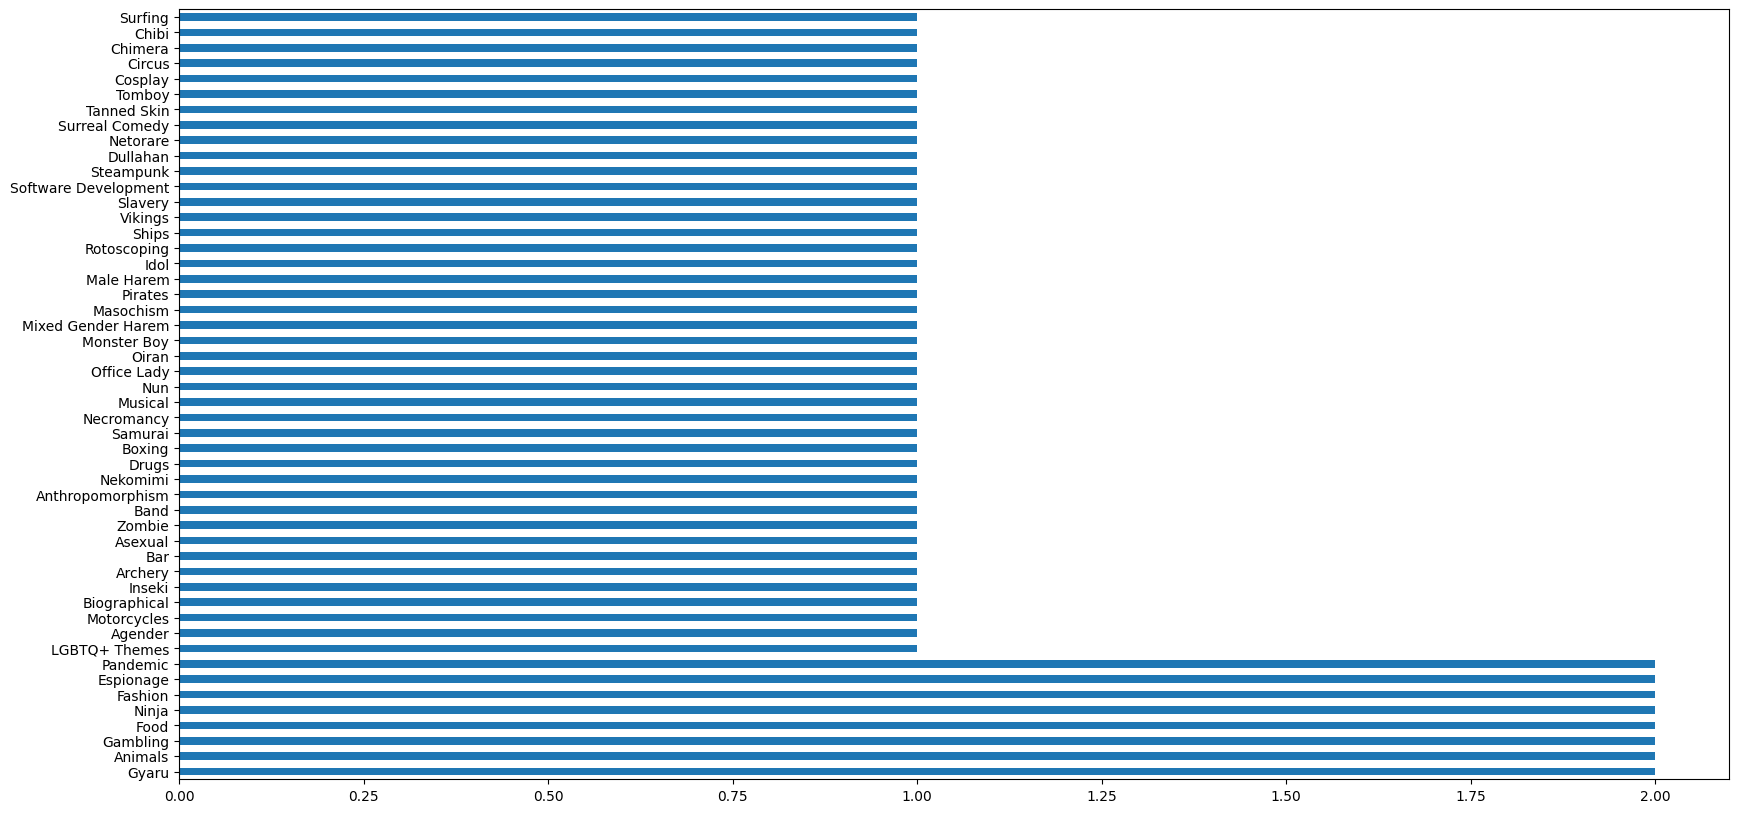

In [10]:
df_final[tags_columns].sum().sort_values(ascending=False).tail(50).plot(kind='barh', figsize=(20, 10))

Trying using tree models for dimension reduction does not return anything interesting.

In [11]:
selected_features = list(compress(tags_columns, df_final[tags_columns].sum()>df_final[tags_columns].sum().quantile(0.90)))

In [12]:
rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=5,
    n_jobs=2,
)
rfecv.fit(df_final[selected_features], df_final['groups'])

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=ExtraTreeClassifier(class_weight='balanced'),
      min_features_to_select=5, n_jobs=2, scoring='accuracy')

In [13]:
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 17


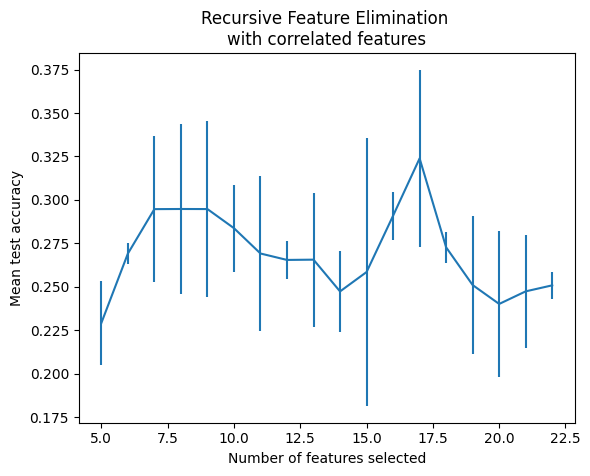

In [14]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(5, n_scores + 5),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

Here we approch using Lasso regression.
<br>
I don't really like this method of reduction because Lasso isn't used for classification problems.

In [19]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import StratifiedKFold

In [35]:
coefs = list()
# hope this is enough penalty given any score.
for alpha in np.linspace(0.001, 0.05, 500):
    lasso = Lasso(alpha=alpha, tol=1e-6, max_iter=int(1e6))
    lasso.fit(df_final[tags_columns], df_final['groups'])
    coefs.append(lasso.coef_)

In [36]:
data = pd.DataFrame(coefs, columns=tags_columns)

with this we can select the features that given the higher penalty they still impactful to the model.

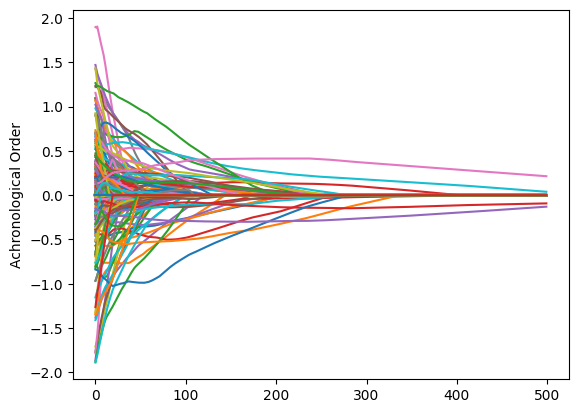

In [37]:
for i in data.columns:
    sns.lineplot(data=data[i], x=data.index, y=data[i])

In [38]:
data['dim_reducted'] = (data==0).sum(axis=1)

with this method we can select the amount of features we want to extract

In [42]:
data.shape

(500, 225)

Ex: given 225 features, let's use only the 25 most impactful.

In [43]:
lasso_selected = list(compress(tags_columns, data[data['dim_reducted']>200].iloc[1]!=0))

In [44]:
df_final[lasso_selected].sum()

Crime                       23.0
Dissociative Identities      8.0
Ensemble Cast               50.0
Environmental               11.0
Gore                        34.0
Iyashikei                   11.0
Magic                       79.0
Monster Girl                 9.0
Politics                    30.0
Primarily Adult Cast        45.0
Primarily Teen Cast         35.0
School                      29.0
Survival                    27.0
Time Manipulation           18.0
Urban                       16.0
Urban Fantasy               44.0
Video Games                 11.0
War                         35.0
Action                     161.0
Mecha                       10.0
Mystery                     61.0
Romance                     75.0
Slice of Life               56.0
dtype: float64

let's fit a tree model just to test how the selected features will do.

In [47]:
model = ExtraTreeClassifier()
model.fit(df_final[lasso_selected], df_final['groups'])

ExtraTreeClassifier()

<AxesSubplot: >

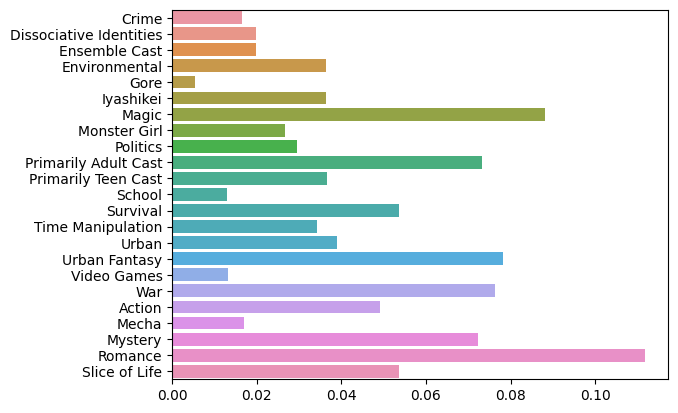

In [50]:
sns.barplot(x=model.feature_importances_, y=lasso_selected)

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

In [52]:
model = GradientBoostingClassifier()
model.fit(df_final[lasso_selected], df_final['groups'])

GradientBoostingClassifier()

<AxesSubplot: >

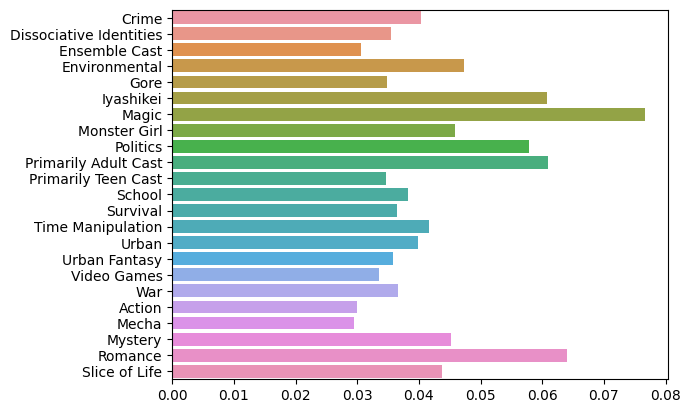

In [53]:
sns.barplot(x=model.feature_importances_, y=lasso_selected)

note that those models are overffited. It's necessary to do a cross validation with hyperparameter testing to choose an actuall useful model.